In [2]:
import os
import random
import sys

import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import tensorflow as tf
import tqdm
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import (
    Activation,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Reshape,
    Softmax,
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.python.client import device_lib



(train_image,train_label),(test_image,test_lable)=tf.keras.datasets.cifar10.load_data()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


170500096/170498071 [==============================] - 6s 0us/step


2 (a) and (b).  Use CIFAR-10 dataset. From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [3]:
bird_class=train_image[(train_label==2).reshape(train_image.shape[0])]
print(bird_class.shape)

(5000, 32, 32, 3)


In [4]:
bird_class_label=train_label[train_label==2]
print(bird_class_label.shape)

(5000,)


In [5]:
bird_class_test=test_image[(test_lable==2).reshape(test_image.shape[0])]
print(bird_class_test.shape)

(1000, 32, 32, 3)


In [6]:
bird_class_label_test=test_lable[test_lable==2]
print(bird_class_label_test.shape)

(1000,)


(c). Those 6000 images have 6000,32,32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [7]:
whole_bird_imageset=np.concatenate((bird_class,bird_class_test))
print(whole_bird_imageset.shape)
whole_bird_labelset=np.concatenate((bird_class_label,bird_class_label_test))
print(whole_bird_labelset.shape)

(6000, 32, 32, 3)
(6000,)


d). Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance.These are the outputs of your network, whose each pixel falls in one of those k classes

In [8]:
from sklearn.cluster import KMeans
#get the input data and input it to the kmeans cluster
#We need to flatten the height and width into a single vector of pixels, hence we reshape it
#So it is a 2 dimensional array with 3 channels (which is RGB)

kmeans=KMeans(n_clusters=4,random_state=99).fit(whole_bird_imageset.reshape(-1,3))
centers=kmeans.cluster_centers_
prediction=kmeans.labels_

In [11]:
centers

array([[157.39425818, 156.9295898 , 137.74989508],
       [ 49.82425629,  50.80100531,  39.15472962],
       [207.85737352, 213.08052223, 212.77882868],
       [110.40524438, 109.95685812,  83.78964519]])

In [19]:
dictionary={'0':[157.39425818, 156.9295898 , 137.74989508],'1':[49.82425629,  50.80100531,  39.15472962],'2':[207.85737352, 213.08052223, 212.77882868],'3':[110.40524438, 109.95685812,  83.78964519]}

In [15]:
prediction_df=pd.DataFrame(prediction)
prediction_df.columns=['cluster_class']
prediction_df

,cluster_class
0,0
1,3
2,3
3,0
4,0
...,...
6143995,0
6143996,0
6143997,0
6143998,0


One hot encode the labels for fitting into model

In [61]:
onehotencoded_y=[]
for ind,r in prediction_df.iterrows():
    if r['cluster_class'] == 0:
        val=[1,0,0,0]
        onehotencoded_y.append(val)
    elif r['cluster_class'] == 1:
        val=[0,1,0,0]
        onehotencoded_y.append(val)
    elif r['cluster_class'] == 2:
        val=[0,0,1,0]
        onehotencoded_y.append(val)
    elif r['cluster_class'] == 3:
        val=[0,0,0,1]
        onehotencoded_y.append(val)
    

In [66]:
arr=np.array(onehotencoded_y)
arr=arr.reshape(-1,32,32,4)
arr

array([[[[1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        ...,

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]],


       [[[0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1

The 'new_list' contains pixels belonging to each of the 4 clusters

In [55]:
new_list=[]
for index,row in prediction_df.iterrows():
    if (row['cluster_class'] == 0):
        val=dictionary['0']
        new_list.append(val)
    elif (row['cluster_class'] == 1):
        val=dictionary['1']
        new_list.append(val)
    elif (row['cluster_class'] == 2):
        val=dictionary['2']
        new_list.append(val)
    elif (row['cluster_class'] == 3):
        val=dictionary['3']
        new_list.append(val)

In [56]:
#This list contains only four cluster colours
len(new_list)

6144000

 e). Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32,32,1 images from the original 32,32,3 images. The grayscale images are inputs of your network.

In [67]:

import cv2
l=[]
for i in whole_bird_imageset:
    img_gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    l.append(img_gray)

l_array=np.array(l)
axismoved = np.moveaxis( l_array,0, 2)
array_4d = np.expand_dims(axismoved,0)
b = np.transpose(array_4d, (3, 1, 2, 0))

X_train, X_test, y_train, y_test = train_test_split(
    b, arr, test_size=0.2, random_state=666)

In [68]:
X_train.shape

(4800, 32, 32, 1)

In [69]:
y_train.shape

(4800, 32, 32, 4)

f). Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. Use 5,5 filters and a softmax output layer.

In [70]:
model=Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same'))

model.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same'))

model.add(Dense(32))
model.add(Activation("softmax"))

#Output consists of 4 classes
#Adding softmax activation function too
model.add(Dense(4))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 4)        

In [71]:
from keras.optimizers import Adam
learning_rate=0.0001
opt=Adam(lr=learning_rate)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

In [72]:
filepath_checkpoint='../Data/cnn_model.hdf5'
checkpoint_callback=ModelCheckpoint(filepath=filepath_checkpoint,save_weights_only=True,monitor='loss',mode='min')
model_loss=model.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test),batch_size=256,callbacks=[checkpoint_callback])

Train on 4800 samples, validate on 1200 samples
Epoch 1/30
4800/4800 [==============================] - 3s 526us/step - loss: 1.3472 - accuracy: 0.2937 - val_loss: 1.3443 - val_accuracy: 0.2977
Epoch 2/30
4800/4800 [==============================] - 2s 463us/step - loss: 1.3223 - accuracy: 0.3456 - val_loss: 1.3037 - val_accuracy: 0.3936
Epoch 3/30
4800/4800 [==============================] - 2s 464us/step - loss: 1.2961 - accuracy: 0.4031 - val_loss: 1.2914 - val_accuracy: 0.4218
Epoch 4/30
4800/4800 [==============================] - 2s 462us/step - loss: 1.2872 - accuracy: 0.4186 - val_loss: 1.2875 - val_accuracy: 0.4242
Epoch 5/30
4800/4800 [==============================] - 2s 463us/step - loss: 1.2838 - accuracy: 0.4270 - val_loss: 1.2840 - val_accuracy: 0.4270
Epoch 6/30
4800/4800 [==============================] - 2s 462us/step - loss: 1.2814 - accuracy: 0.4334 - val_loss: 1.2820 - val_accuracy: 0.4342
Epoch 7/30
4800/4800 [==============================] - 2s 462us/step - loss

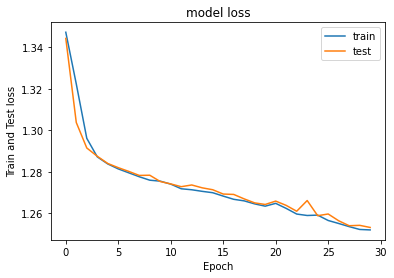

In [73]:
plt.plot(model_loss.history['loss'],label='train')
plt.plot(model_loss.history['val_loss'],label='test')
plt.title('model loss')
plt.ylabel('Train and Test loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
